<a href="https://colab.research.google.com/github/lmendezayl/uba-ldd-tp2/blob/main/TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico N°2

Integrantes:
- Lautaro Evaristo Mendez
- Franco Zalazar
- Luca Petrarca



*- In god we trust, all others must bring data.*

*W. E. Demings*






In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.objects as so
import nltk

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

from sklearn.datasets import make_blobs, make_circles
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA

## Clustering [4 pts.]



Nuestro primer objetivo es realizar un agrupamiento de las noticias de deportes por temas. En este caso, no tenemos una respuesta correcta que queremos predecir. Queremos realizar un agrupamiento y ver si podemos identificar temas en los grupos que obtenemos.



**Bag-of-words** Queremos generar primero columnas indicadoras de las palabras que aparecen en el texto, una columna por cada palabra. Este enfoque tan simple tiene el problema de que la misma palabra pero en singular/plural o un verbo en distintos tiempos verbales serían identificados como palabras distintas, y tendríamos demasiadas palabras y pocas repeticiones. Para evitar esto, una técnica común es utilizar las raíces de las palabras (stems). Por ejemplo, las raíces de las palabras ”comida” y ”comer” será ”com” (esto puede generar algunas identificaciones incorrectas pero en general funciona bastante bien). Para obtener las raíces de las palabras vamos a usar SnowballStemmer de la biblioteca nltk. Otro problema es que palabras que funcionan como conectores (por ejemplo because, any, above, ...) no aportan información sobre el contenido del texto y es conveniente eliminarlas. En inglés, en el contexto de modelos de lenguaje, estas palabras se llaman stop words (son palabras que queremos frenar antes de procesar los textos). La biblioteca `nltk` provee un listado de stop words que podemos utilizar.



### Ejercicio 1.
Cargar en un DataFrame `df_news` los datos del archivo noticias.csv.


In [ ]:
# Manejo de load en local u online
try:
    df_news = pd.read_csv('noticias.csv')
except:
    df_news = pd.read_csv('https://raw.githubusercontent.com/lmendezayl/uba-ldd-tp2/refs/heads/main/noticias.csv')

In [ ]:
# Mostramos el dataframe
df_news.head(3)

,title,content,category
0,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarner...,business
1,Dollar gains on Greenspan speech,The dollar has hit its highest level against t...,business
2,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuko...,business



### Ejercicio 2.
Crear un DataFrame `df_sports` que contenga solo las noticias de la categoría deportes, y resetear los índices.


Veamos como se llaman especificamente las categorias.

In [ ]:
df_news.category.unique()

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

Elegimos las noticias que pide el ejericio.

In [ ]:
df_sports = df_news[df_news['category'] == 'sport'].reset_index().drop(columns='index')
df_sports.head(3)

,title,content,category
0,Claxton hunting first major medal,British hurdler Sarah Claxton is confident she...,sport
1,O'Sullivan could run in Worlds,Sonia O'Sullivan has indicated that she would ...,sport
2,Greene sets sights on world title,Maurice Greene aims to wipe out the pain of lo...,sport



### Ejercicio 3.
Generar un DataFrame `df_sports_stems` que contenga una columna por cada stem que aparece en los contenidos de las noticias de deportes, excluyendo las stop words. Para cada noticia, cada columna indica la cantidad de veces que aparece esa palabra en la noticia. Pueden utilizar el siguiente código.


In [ ]:
nltk.download("stopwords")
nltk.download('punkt_tab')
stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer(language = "english")
# Generamos una lista con todos los stems de palabras del texto
# (excluyendo stop words y palabras que tienen numeros o simbolos)

def tokenize_and_stem(text):
    tokens = word_tokenize(text.lower())
    stems = [stemmer.stem(token) for token in tokens if (token.isalpha() and token not in stop_words)]
    return stems
vectorizer = CountVectorizer(analyzer=tokenize_and_stem)
X = vectorizer.fit_transform(df_sports["content"])
df_sports_stems = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Visualizamos `df_sports_stems`

In [ ]:
print(df_sports_stems.shape)
df_sports_stems.head()

(511, 7193)


,aaa,aac,aaron,abandon,abat,abbott,abc,abdomen,abdomin,abeb,...,zimbabw,zinc,zinedin,zoe,zola,zone,zornotza,zuluaga,zurich,zvonareva
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



### Ejercicio 4. Visualización.
Para poder visualizar las noticias y ver si se forman grupos de noticias, calcular las dos primeras componentes principales $Z_1$ y $Z_2$ del DataFrame `df_sports_stems` y realizar un gráfico de dispersión de $Z_1$ vs. $Z_2$.


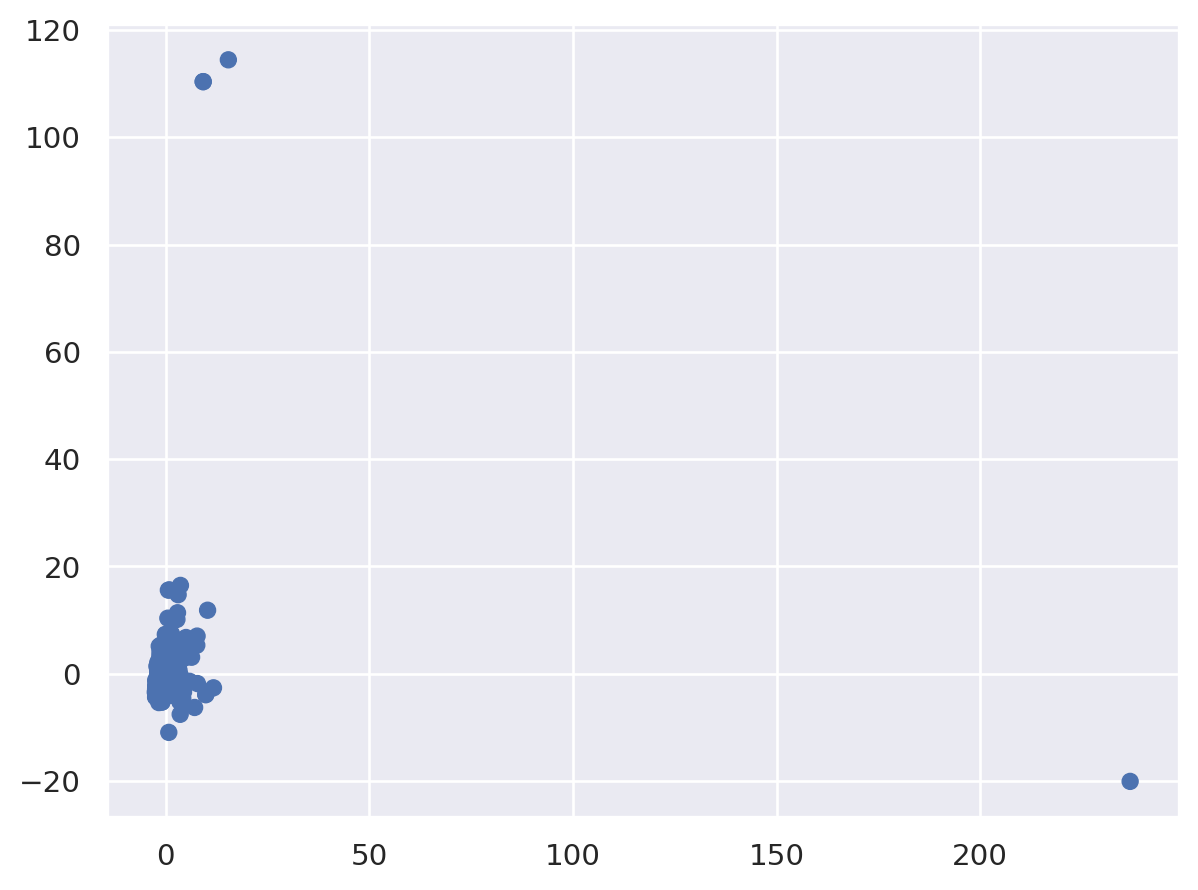

In [ ]:
# Escalamos a media 0 con distibución normal
df_ss_scaled = StandardScaler().set_output(transform="pandas").fit_transform(df_sports_stems)

# Aplicamos PCA
pca = PCA(n_components=2)

# Calculamos los Z1 y Z2
principalComponents = pca.fit_transform(df_ss_scaled)

# Realizamos grafico de dispersión
(
    so.Plot(x = principalComponents[:,0], y = principalComponents[:,1])
    .add(so.Dot())
    # agregar nombre, prettify
)


### Ejercicio 5.
¿Pueden observar grupos en esta visualización? ¿Cuál puede ser el problema?



**TF-IDF.** El enfoque bag-of-words es demasiado simple. Hay palabras que aparecen mucho en los textos (como por ejemplo ”today” o ”say”) que no sirven para relacionar artículos con temáticas parecidas. Queremos darle poco peso a estas palabras. Por el contrario, si una palabra aparece en solo 3 noticias, podemos imaginar que esas 3 noticias están relacionadas. Queremos darle más peso a palabras poco frecuentes.

Una métrica usual que da muy buenos resultados es la llamada TF-IDF.
El término TF (term frequency) es la frecuencia de la palabra en el texto, normalizada:

$$\text{TF}(t, d) = \frac{\text{cantidad de veces que la palabra } t \text{ aparece en el texto } d}{||\text{vector de frecuencias del documento } d||_2}$$

donde el denominador es $\sqrt{\sum_{t′} f^2_{t′,d}} $,  la raíz cuadrada de la suma de los cuadrados de las frecuencias de todos los términos en el documento $d$ (similar a la cantidad total de palabras en el texto). El término IDF (inverse document frequency) es el logaritmo del cociente entre el total de documentos y el número de documentos que contienen un término, más uno:

$$
\text{IDF}(t, D) = log\left(\frac{\text{número total de documentos en el corpus } D}{ \text{cantidad de documentos en el corpus } D \text{ que tienen la palabra }t}\right) + 1
$$

Finalmente, definimos
$$\text{TF-IDF}(t, d, D) = \text{TF}(t, d) × \text{IDF}(t, D)$$
Esta métrica no es difícil de calcular a partir de las variables que ya calculamos, pero podemos también hacerlo automáticamente a través del comando `TfidfVectorizer`.



### Ejercicio 6.
Generar un DataFrame `df_sports_tfidf` que contenga una columna por cada stem que aparece en los contenidos de las noticias de deportes. Para cada noticia, cada columna indica el valor de TF-IDF. Pueden utilizar el siguiente código.


In [ ]:
# Text vectorization using TF-IDF
vectorizer = TfidfVectorizer(analyzer=tokenize_and_stem, smooth_idf=False)
X = vectorizer.fit_transform(df_sports["content"])
df_sports_tfidf = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
df_sports_tfidf.head()

,aaa,aac,aaron,abandon,abat,abbott,abc,abdomen,abdomin,abeb,...,zimbabw,zinc,zinedin,zoe,zola,zone,zornotza,zuluaga,zurich,zvonareva
0,0.090095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



### O1. (Opcional.)
Para la raíz ***abandon***, calcular mediante funciones usuales el valor de TF-IDF para la noticia deportiva 246 (con título ***Real will finish abandoned match***). Comparar el valor en la tabla generada
 con el valor que obtuvieron a mano en el ítem anterior.



### Ejercicio 7. Visualización.
Calcular las dos primeras componentes principales $Z_1$ y $Z_2$ del DataFrame
`df_sports_tfidf` y realizar un gráfico de dispersión de $Z_1$ vs. $Z_2$. ¿Pueden observar agrupamientos en esta visualización?


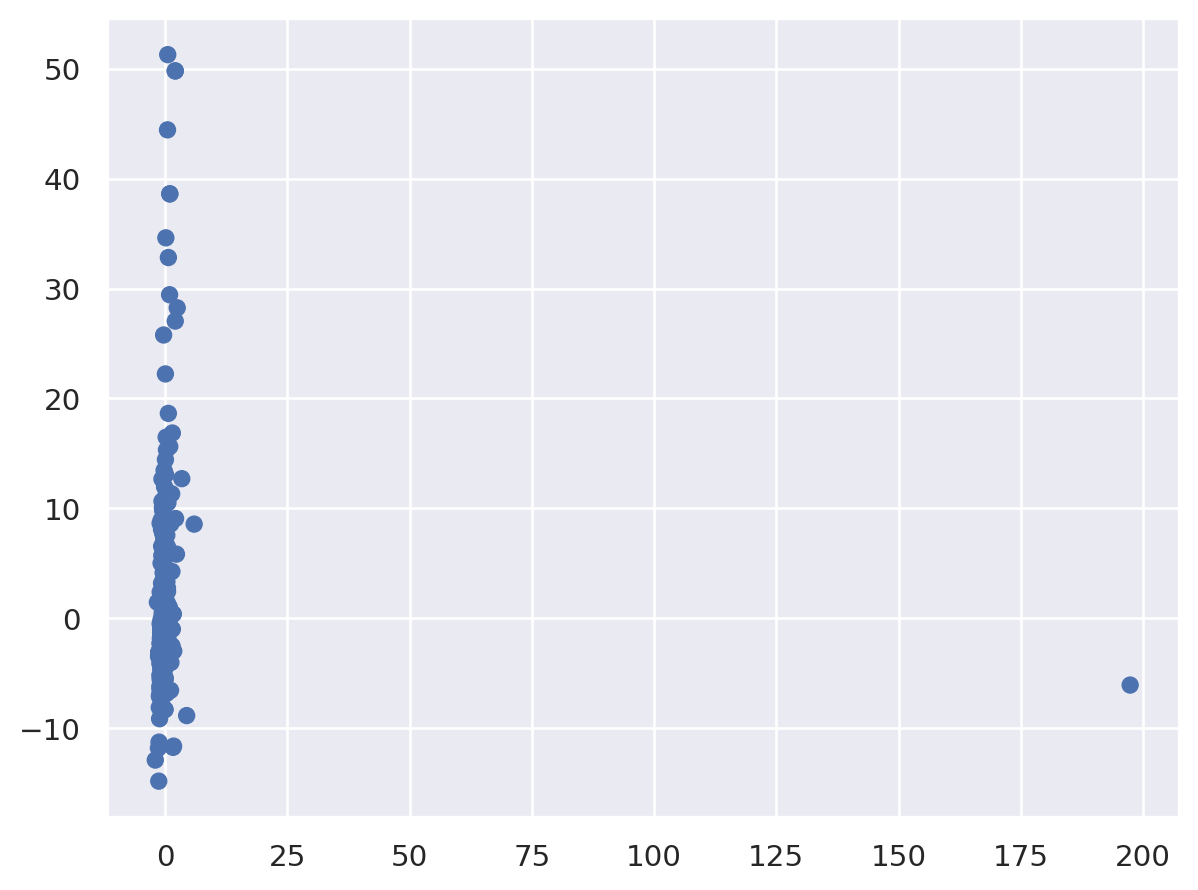

In [ ]:
# Escalamos a media 0 con distibución normal
df_sports_scaled_tfidf = StandardScaler().set_output(transform="pandas").fit_transform(df_sports_tfidf)

# Aplicamos PCA
pca = PCA(n_components=15)

# Calculamos los Z1 y Z2
principalComponents = pca.fit_transform(df_sports_scaled_tfidf)

# Realizamos grafico de dispersión
(
    so.Plot(x = principalComponents[:,0], y = principalComponents[:,1])
    .add(so.Dot())
    # agregar nombre, prettify
)


### Ejercicio 8. Clustering.
Realizar un agrupamiento de los datos por algún método de clustering entre los
vistos en clase (K-means o DB-scan). Utilizar todas las columnas de datos (no las componentes principales), seleccionado los hiperparámetros por algún mecanismo que consideren apropiado.



### Ejercicio 9.
Colorear los puntos del gráfico de dispersión de PCA según las etiquetas de los clusters. ¿Quedan los puntos de cada cluster ubicados cerca en esta visualización?



### Ejercicio 10. Identificación de temáticas.
Queremos identificar las temáticas de algunos de estos clusters. Para esto pueden utilizar cualquier estrategia que consideren apropiada. Por ejemplo,
- ver los títulos o contenidos de las noticias en algunos clusters.
- si algunas de las componentes principales distingue clusters, ver qué palabras tienen peso en esa componente. Por ejemplo, si vemos que un cluster corresponde a noticias con coordenada $Z_1$ alta, analizamos en las coordenadas de la dirección principal correspondiente qué palabras tienen el mayor peso positivo.

Algunos clusters pueden no tener una temática clara. Identificar temáticas en al menos 2 clusters del agrupamiento.



## Clasificación [4 pts.]



Trabajamos ahora con toda la base de datos. Queremos predecir la categoría de cada artículo según el contenido del texto. Nuevamente vamos a utilizar la métrica TD-IDF y suponer que noticias cercanas en esta métrica corresponden a noticias de temática similar.



### Ejercicio 11.
Generar un DataFrame `df_news_tfidf` que contenga una columna por cada stem que aparece en los contenidos de todas las noticias. Para cada noticia, cada columna indica el valor de TF-IDF (utilicen el mismo código de antes para generar este DataFrame).



### Ejercicio 12. Visualización.
Calcular las dos primeras componentes principales $Z_1$ y $Z_2$ del DataFrame
`df_news_tfidf` y realizar un gráfico de dispersión de $Z_1$ vs. $Z_2$, coloreando cada punto según la categoría del artículo.
¿Quedan las noticias de cada categoría ubicadas cerca en esta visualización?



### O2. (Opcional.)
¿Qué palabras tienen peso positivo alto y peso negativo alto en estas dos compo-
nentes?



### Ejercicio 13.
Predecir la categoría de cada artículo utilizando KNN. Para esto:
 1. separar el conjunto total de datos en un 80% para entrenamiento y un 20% para testeo
 2. seleccionar el valor de K (entre números impares del 1 al 19 ambos inclusive) por algún esquema de validación apropiado en el conjunto de entrenamiento (*train-validation*, *cross-validation*, *leave-one-out*),
 3. para el valor hallado, calcular la precisión del método (porcentaje de aciertos) en el conjunto de testeo.



### O3. (Opcional.) Maldición de la dimensionalidad.
Vimos que al utilizar muchas variables explicativas podemos caer en la maldición de la dimensionalidad. Una estrategia posible para evitar esto es usar las componentes principales para clasificación. ¿Cuántas componentes tenemos que tomar si queremos que esas componentes expliquen al menos un 10% de la varianza total? Definir un DataFrame $Z$ que contenga esas componentes y repetir el ejercicio anterior. ¿Mejoró la precisión del método?



## Clasificación utilizando títulos de las noticias [2 pts.]



Hasta ahora utilizamos el contenido de las noticias para clasificar. En estas noticias los títulos son muy breves y resulta más difícil utilizarlos para clasificar.



### Ejercicio 14.
Generar un DataFrame `df_titles_tfidf` que contenga una columna por cada stem que aparece en los títulos de las noticias. Para cada noticia, cada columna indica el valor de TF-IDF.



### O4. (Opcional.) Aplicar KNN como en la sección anterior para clasificación de la categoría utilizando solo los títulos de las noticias. ¿Qué porcentaje de aciertos obtenemos?



Vamos a enfocarnos ahora en predecir correctamente qué artículos corresponden a la categoría de entretenimiento.



### Ejercicio 15.
Definir una nueva serie entretenimiento que tome valor 1 si la categoría es entretenimiento y 0 si no. Aplicar KNN como en la sección anterior para clasificación de la categoría entrenimiento utilizando solo los títulos de las noticias (es decir, para predecir la variable entretenimiento). ¿Qué porcentaje de aciertos obtenemos?



### Ejercicio 16.
Proponer otro modelo de clasificación para predecir el valor de esta variable. Puede ser un modelo de regresión lineal, logística, red neuronal o cualquier otro modelo.



### Ejercicio 17.
Utilizando los mismos conjuntos de entrenamiento y testeo de la sección anterior, calcular los parámetros e hiperparámetros del modelo en el conjunto de entrenamiento y calcular el porcentaje de aciertos en el conjunto de testeo. Comparar con KNN. (No se preocupen si no obtienen un porcentaje mayor al de KNN, mientras sigan los pasos correctos para ajustar el modelo.)